# Chapter 14: Deep Computer Vision Using Convolutional Neural Networks


This notebook contains the solution for the exercises 9, 10 and 11 of the chapter 14: *Deep Computer Vision Using Convolutional Neural Networks* of the book *Hands On Machine Learning with Scikit-Learn, Keras & TensorFlow* of Aurélien Géron.

## Import and Configure Modules

In [1]:
import os 
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

import tensorflow as tf
from tensorflow.keras import (
    applications,
    models,
    layers,
    optimizers,
)
import tensorflow_hub as hub

In [2]:
def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [3]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

## Visualize the input

In [4]:
# Loads the image and limits its maximum dimension to 512

def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    new_shape = tf.cast(shape * scale, tf.int32)
    
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    
    return img 

In [5]:
# Displays the image

def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    
    plt.imshow(image)
    if title:
        plt.title(title)

Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2022-03-01 16:24:58.887746: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-01 16:24:58.887888: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


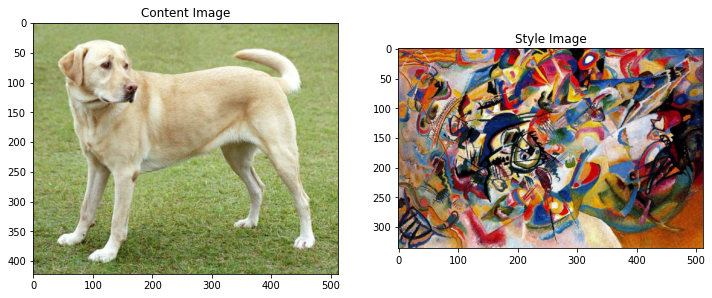

In [6]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

2022-03-01 16:25:02.088591: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-01 16:25:02.088939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


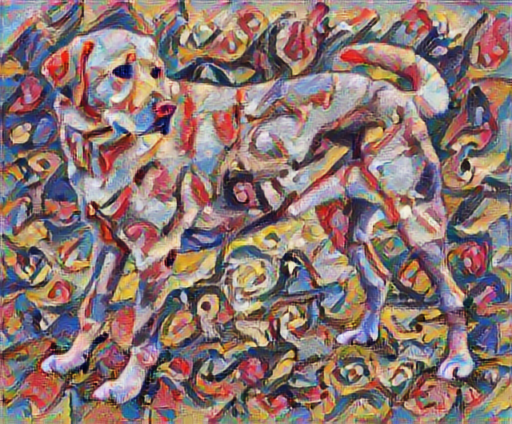

In [7]:
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

In [8]:
x = applications.vgg19.preprocess_input(content_image * 255)
x = tf.image.resize(x, (224, 224))
vgg = applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [9]:
predicted_top_5 = applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('Labrador_retriever', 0.49317187),
 ('golden_retriever', 0.23665284),
 ('kuvasz', 0.0363575),
 ('Chesapeake_Bay_retriever', 0.024182664),
 ('Greater_Swiss_Mountain_dog', 0.01864606)]

In [10]:
# Let's load the VGG19 model without the top layers and list the layers
vgg = applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
    print(layer.name)


input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [11]:
# Let's choose intermdiate layers from the network to represent style and content
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

## Build The Model

In [12]:
# Let's retun the list of intermediate layers defined before

def vgg_layers(layer_names):
    vgg = applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

In [13]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image * 255)

for name, output in zip(style_layers, style_outputs):
    print(name)
    print('     shape : ', output.numpy().shape)
    print('     min : ', output.numpy().min())
    print('     max : ', output.numpy().max())
    print('     mean : ', output.numpy().mean())
    print()

block1_conv1
     shape :  (1, 336, 512, 64)
     min :  0.0
     max :  835.52563
     mean :  33.97525

block2_conv1
     shape :  (1, 168, 256, 128)
     min :  0.0
     max :  4625.8774
     mean :  199.82689

block3_conv1
     shape :  (1, 84, 128, 256)
     min :  0.0
     max :  8789.237
     mean :  230.78094

block4_conv1
     shape :  (1, 42, 64, 512)
     min :  0.0
     max :  21566.154
     mean :  791.24005

block4_conv1
     shape :  (1, 42, 64, 512)
     min :  0.0
     max :  21566.154
     mean :  791.24005

block5_conv1
     shape :  (1, 21, 32, 512)
     min :  0.0
     max :  3189.235
     mean :  59.17949



## Calculate Style

In [14]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / (num_locations)

## Extract Style and Content

In [15]:
# Build a model that returns the style and content tensors

class StyleContentModel(models.Model):
    
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False
        
    def call(self, inputs):
        'Expects flaot input in [0, 1]'
        
        inputs = inputs * 255.0
        preprocessed_input = applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                           outputs[self.num_style_layers:])
        
        style_outputs = [gram_matrix(style_output) 
                         for style_output in style_outputs]
        
        content_dict = {content_name:value 
                        for content_name, value 
                        in zip(self.content_layers, content_outputs)}
        
        style_dict = {style_name : value 
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}
        
        return {'content' : content_dict, 'style' : style_dict}

In [16]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles: ')
for name, output in sorted(results['style'].items()):
    print(f'    {name}')
    print(f'    shape : {output.numpy().shape}')
    print(f'    min : {output.numpy().min()}')
    print(f'    max : {output.numpy().max()}')
    print(f'    mean : {output.numpy().mean()}')

Styles: 
    block1_conv1
    shape : (1, 64, 64)
    min : 0.005522644612938166
    max : 28014.564453125
    mean : 263.7903137207031
    block2_conv1
    shape : (1, 128, 128)
    min : 0.0
    max : 61479.5390625
    mean : 9100.951171875
    block3_conv1
    shape : (1, 256, 256)
    min : 0.0
    max : 545623.5625
    mean : 7660.9775390625
    block4_conv1
    shape : (1, 512, 512)
    min : 0.0
    max : 4320503.5
    mean : 134288.859375
    block5_conv1
    shape : (1, 512, 512)
    min : 0.0
    max : 110005.2421875
    mean : 1487.03759765625


## Run Gradient Descent

In [17]:
# Set the style and content target values
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [18]:
image = tf.Variable(content_image)

In [19]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [20]:
optimizer = optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

# Set loss weights 
style_weight = 1e-2
content_weight = 1e4

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name]) ** 2)
                           for name in style_outputs.keys()])
    
    style_loss *= style_weight / num_style_layers
    
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name]) ** 2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [21]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
    
    grad = tape.gradient(loss, image)
    optimizer.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

2022-03-01 16:25:08.130237: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


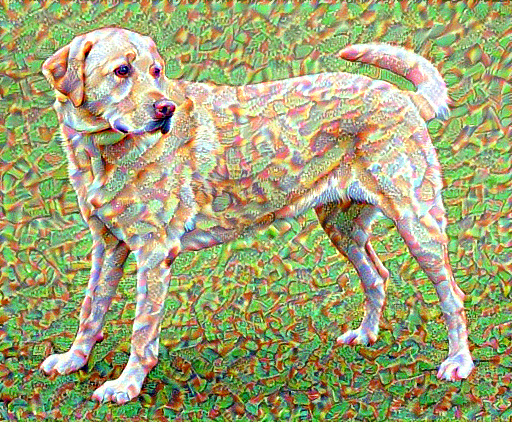

In [22]:
train_step(image)
train_step(image)
train_step(image)
train_step(image)
train_step(image)
train_step(image)
train_step(image)
train_step(image)
train_step(image)
train_step(image)
train_step(image)
train_step(image)
train_step(image)
train_step(image)
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

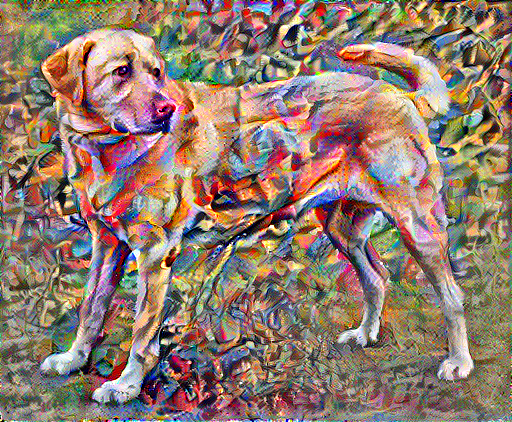

Train step : 1000
Total time: 136.22550129890442


In [23]:
# Now let's perform longer optimization
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print('.', end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print(f'Train step : {step}')

end = time.time()
print(f'Total time: {end - start}')

## Total Variation Loss

In [24]:
def high_pass_x_y(image):
    x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
    y_var = image[:, 1:, :, :] - image[:, :-1, :, :]
    
    return x_var, y_var

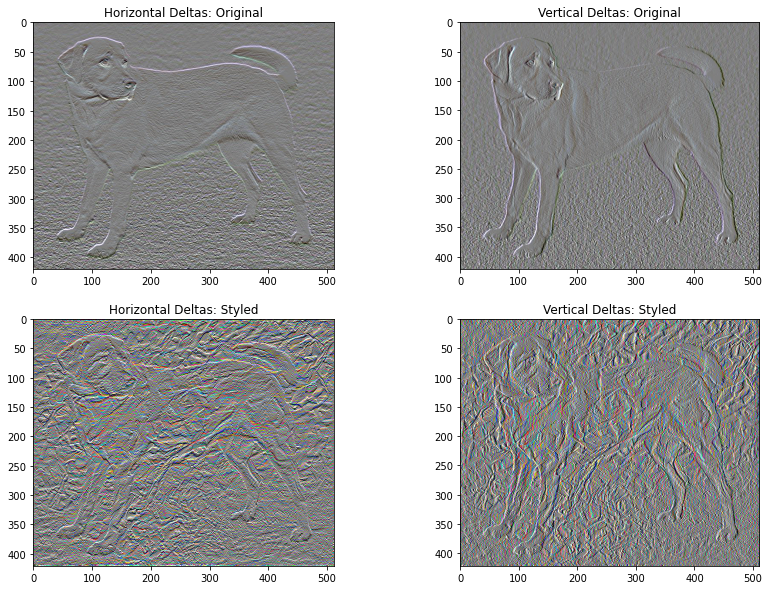

In [25]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2 * y_deltas + 0.5), 'Horizontal Deltas: Original')

plt.subplot(2, 2, 2)
imshow(clip_0_1(2 * x_deltas + 0.5), 'Vertical Deltas: Original')

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2 * y_deltas + 0.5), 'Horizontal Deltas: Styled')

plt.subplot(2, 2, 4)
imshow(clip_0_1(2 * x_deltas + 0.5), 'Vertical Deltas: Styled')

## Re-Run the Optimization

In [26]:
total_variation_weight = 30

In [27]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss += total_variation_weight ** tf.image.total_variation(image)
    
    grad = tape.gradient(loss, image)
    optimizer.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

In [28]:
image = tf.Variable(content_image)

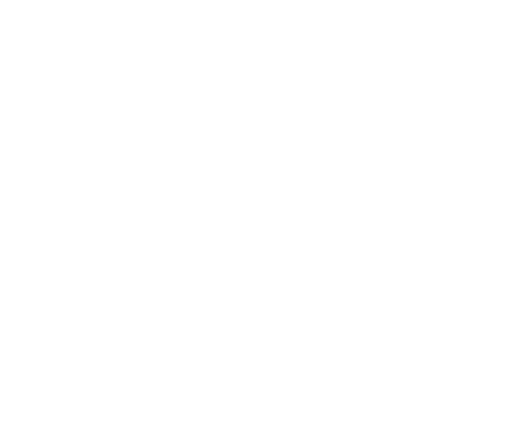

Train step: 2500
Total time : 348.4044449329376


In [29]:
start = time.time()

epochs = 25
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print('-', end='>', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print(f'Train step: {step}')

end = time.time()
print(f'Total time : {end - start}')